In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
!python  '/workspaces/predictive_maintenance/src/agg_telemetry.py'

In [3]:
df_failures_telemetry_path  = '../data/processed/training_data/df_failures_telemetry_agg.parquet'
df_failures_telemetry_agg = pd.read_parquet(df_failures_telemetry_path)

## Original Data

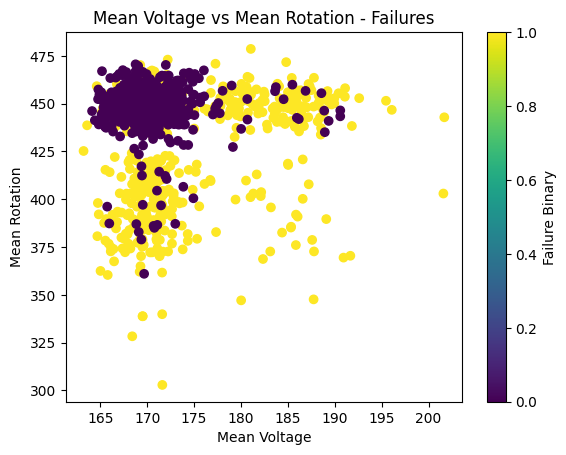

In [4]:

# split X and y
X = df_failures_telemetry_agg.drop(columns=['failure', 'failure_binary'])
y_bin = df_failures_telemetry_agg['failure_binary']
y_cat = df_failures_telemetry_agg['failure']

# plot mean_volt vs mean_rot and use color to show failure
scatter = plt.scatter(X['mean_volt'], X['mean_rot'], c=y_bin, cmap='viridis')

# add axis labels, color bar, and title
plt.xlabel('Mean Voltage')
plt.ylabel('Mean Rotation')
plt.colorbar(scatter, label='Failure Binary')
plt.title('Mean Voltage vs Mean Rotation - Failures')

# display the plot
plt.show()


# Clusters

In [7]:
class PCAClustering:
    def __init__(self, df, n_clusters, apply_pca=True):
        self.df = df
        self.n_clusters = n_clusters
        self.apply_pca = apply_pca
        self.df_transformed = None
        self.centroids = None

    def prepare_data(self):
        X = self.df.drop(columns=['failure', 'failure_binary'])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        if self.apply_pca:
            pca = PCA()
            X_transformed = pca.fit_transform(X_scaled)
        else:
            X_transformed = X_scaled
        columns = [f'PC{i+1}' for i in range(X_transformed.shape[1])]
        self.df_transformed = pd.DataFrame(X_transformed, columns=columns)

    def train_cluster_model(self):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        kmeans.fit(self.df_transformed)
        cluster_labels = kmeans.labels_
        self.centroids = kmeans.cluster_centers_
        self.df_transformed['Cluster'] = cluster_labels

    def plot_clusters(self):
        scatter = plt.scatter(self.df_transformed.iloc[:, 0], self.df_transformed.iloc[:, 1], c=self.df_transformed['Cluster'], cmap='viridis')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', marker='x', label='Centroids')
        plt.xlabel(self.df_transformed.columns[0])
        plt.ylabel(self.df_transformed.columns[1])
        plt.colorbar(scatter, label='Assigned Cluster')
        plt.legend()
        plt.title(f'{self.df_transformed.columns[0]} vs {self.df_transformed.columns[1]} - KMeans Clustering with {self.n_clusters} Clusters')
        plt.show()

        
    def plot_silhouette_score(self):
        if self.df_transformed is None:
            print("Please run the clustering process before plotting the silhouette score.")
            return
        X = self.df_transformed.drop(columns=['Cluster'])
        labels = self.df_transformed['Cluster']
        silhouette_avg = silhouette_score(X, labels)
        sample_silhouette_values = silhouette_samples(X, labels)
        fig, ax = plt.subplots()
        y_lower = 10
        n_clusters = self.n_clusters
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax.set_xlabel("Silhouette Coefficient Values")
        ax.set_ylabel("Cluster Label")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([])
        ax.set_title("Silhouette Plot")
        plt.show()


    def plot_elbow_curve(self, max_clusters=10):
        X = self.df_transformed.drop(columns=['Cluster']) if self.df_transformed is not None else self.prepare_data()

        inertias = []
        ks = range(1, max_clusters + 1)

        for k in ks:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X)
            inertias.append(kmeans.inertia_)

        plt.figure()
        plt.plot(ks, inertias, marker='o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
        plt.title('Elbow Curve')
        plt.show()
        
    def run(self):
        self.prepare_data()
        self.train_cluster_model()
        self.plot_clusters()
        return self.df_transformed


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


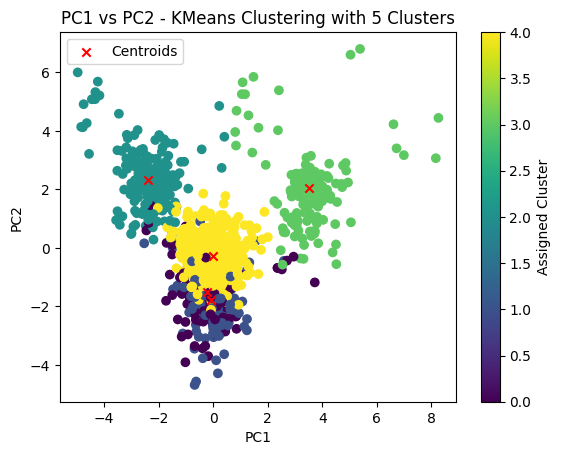

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
n_clusters = 5

pca_clustering = PCAClustering(df_failures_telemetry_agg, n_clusters=n_clusters, apply_pca=True)
df_pca_clusters = pca_clustering.run()


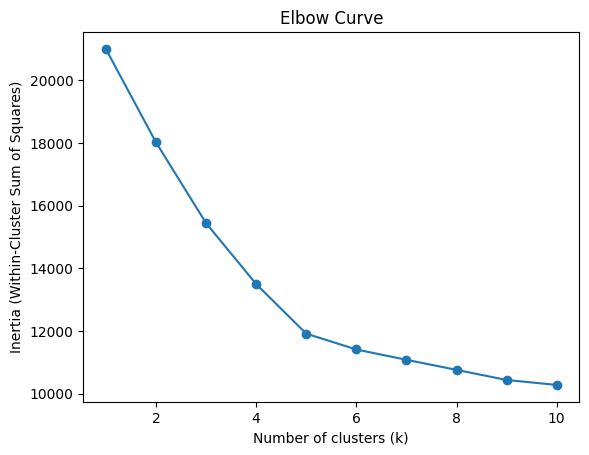

In [10]:
pca_clustering.plot_elbow_curve(max_clusters=10)

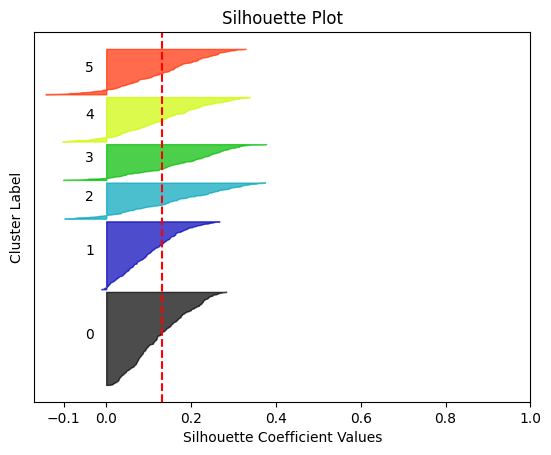

In [20]:
pca_clustering.plot_silhouette_score()

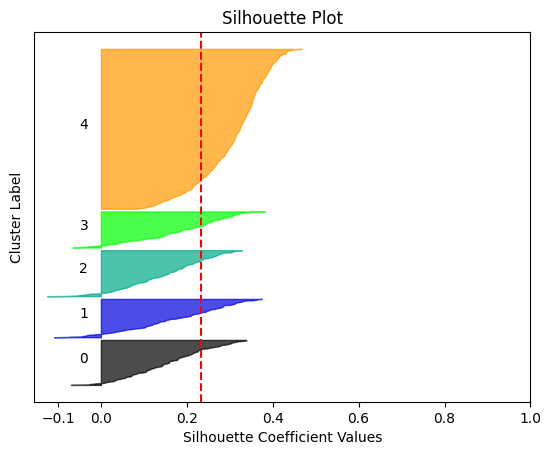

In [12]:
pca_clustering.plot_silhouette_score()